## Generative Models - Autoencoders and GANs 

Michel Kana


<hr style="height:2pt">

In [241]:

import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split


from keras.models import Sequential, Model, load_model
from keras.layers import Activation, GlobalAveragePooling2D, Deconvolution2D, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization, Concatenate, LeakyReLU
from keras.utils import np_utils, to_categorical, Sequence
from keras.losses import binary_crossentropy, mse
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import RandomNormal
import random


In [3]:
# check GPU availability
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [270]:
import cv2, glob
import skimage
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
from IPython.display import clear_output

## Part 1: Making Faces </b></div>

We'll be using a subset of the Celeb A dataset to help us build facial generative models, as described on the [Celeb A](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) website. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. 

CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,
- 202,599 number of face images, 
- 5 landmark locations, and 
- 40 binary attributes annotations per image.

### Section A:  Preparing the Data


**1.A.1. Download the dataset from: [CelebA Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip).** 

The code below is used to download the celebrity images.

In [5]:
'''
import requests, zipfile, io
r = requests.get('https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
'''

"\nimport requests, zipfile, io\nr = requests.get('https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/celeba-dataset.zip')\nz = zipfile.ZipFile(io.BytesIO(r.content))\nz.extractall()\n"

**1.A.2. Load the attribute data in `list_attr_celeba.csv` into a pandas dataframe.**

In [6]:
df_celeb = pd.read_csv('data/celeb/list_attr_celeba.csv')

In [7]:
df_celeb.shape

(202599, 41)

In [8]:
df_celeb.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**1.A.3. Pick 3 random images from the dataset, plot them, and verify that the attributes are accurate.**

The function below is used to randomly select one or many faces and eventually display them.

In [9]:
def show_sample_image(nb=3, df=df_celeb, verbose=True):
    '''
        Function picks random faces from the celebrity dataset, 
        It plots the faces and returns the last one including its metadata
        Args:
         df: dataframe with celebrity faces' metadata
         nb: number of faces to display
         verbose: if False, do not display the faces, only return the last face chosen.
        Output
         - an image of the last celebrity face selected
         - the metadata of the last celebrity face selected
    '''
    f, ax = plt.subplots(1, nb, figsize=(10,5))
    for i in range(nb):
        idx = random.randint(0, df.shape[0]-1)
        img_id = df.loc[idx].image_id
        img_uri = 'data/celeb/img_align_celeba/' + img_id
        img = skimage.io.imread(img_uri)  
        if verbose:
            label = img_id
            for col in df.columns:
                if df.loc[idx][col]==1:
                    label = label + '\n' + col  
            if nb > 1:
                ax[i].imshow(img)
                ax[i].set_title(label)
            else:
                ax.imshow(img) 
                ax.set_title(label)
        
    return img, list(df.loc[idx][1:df.shape[1]])

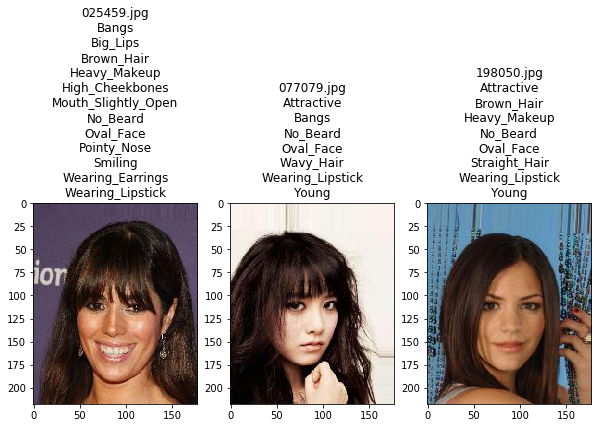

In [10]:
sample_img, sample_img_meta = show_sample_image()

Attributes look accurate.

In [11]:
print('The images are {}px height, {}px width with {} color channels.'.format(sample_img.shape[0],sample_img.shape[1],sample_img.shape[2]))

The images are 218px height, 178px width with 3 color channels.


### Section B: Building and Training a Variational Autoencoder Model 

**1.B.1. Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  Print summaries for the encoder, decoder and full autoencoder models.**

An Autoencoder is made of a pair of two connected networks: an encoder model and a decoder model. Its goal is to find a way to encode the celebrity faces into a compressed form (latent space) in such a way that the decoded version is as close as possible to the input. The encoder model turns the input into a small dense representation, similar to how a convulational neural network works by using filters to learn representations. The decoder model can be seen as a generative model which is able to generate specific features. Both encoder and decoder are usually trained as a whole. The loss function penalizes the network for creating output faces which differ from input faces. Therefore the encoder learns to preserve as much of the relevant information needed in the limitation of the laten space, and cleverly discard irrelevant parts, e.g. noise. The decoder learns to take the compressed latent information and reconstruct it into a full celebrity face. An Autoencoder can be useful for dimensionality reduction and denoising images, but can also be successful in [unsupervized machine translation](https://arxiv.org/pdf/1710.11041.pdf). 

Typically, the latent space produced by the encoder is sparsely populated, meaning that it is difficult to predict the distribution of values in that space. Values are scattered and the space will appear to be well utilized in a 2D representation. This is a very good property for compression systems. However for generating new celebrity images this sparsity is an issue, because finding a latent value for which the decoder will know how to produce valid image is almost impossible. Futhermore if the space has gaps between clusters, and the decoder receives a variation from there, it will lack the knowledge to generate something useful. 

Variational Autoencoder works by making the latent space more predictable, more continuous, less sparse. By forcing latent variables to become normally distributed, we gain control over the latent space. Instead of forwarding the latent values to the decoder directly, we use them to calculate a mean and a standard deviation. The input to the decoder are then sampled from the corresponding normal distribution. During training, we force this normal distribution to be as close as possible to the standard normal distribution by including the Kullback–Leibler divergence in the loss function. VAE will be altering, or exploring variations on the faces, and not just in a random way, but in a desired, specific direction.

**Data Generator**

We use a custom Keras memory-efficient generator in order to deal with our large dataset (202599 images, ca. 10KB each). The idea behind is to get batches of images on the fly during training process. The class below is adapted from [CompuFest](https://github.com/Harvard-IACS/2019-computefest/blob/master/Wednesday/auto_encoder/VAE_Solutions.ipynb) to work with dataframes. It supports Conditional Variational Autoencoder, which allows to model X based on both the latent variable z and additional information such as metadata of the face.

In [367]:
class CustomCelebrityFaceGenerator(Sequence):
    def __init__(self, df, batch_size, target_height, target_width, conditioning_dim=0):
        '''
        This function intializes the custom celebrity face generator.
        
        Args:
            df: dataframe of image filenames and attributes.
            batch_size: batchsize.
            target_height: target image height. Images are resized to this height.
            target_width: target image width. Images are resized to this width.
            conditioning_dim: number of metadata point describing each face. 0 if no conditioning is used.
        '''
        self.df = df
        self.batch_size = batch_size
        self.target_height = target_height
        self.target_width = target_width
        self.conditioning_dim = conditioning_dim

    def on_epoch_end(self):
        # we shuffle the images after each epoch, by shuffling the dataframe.
        self.df = self.df.sample(frac=1)
        
    def __getitem__(self, index):
        # we select the current batch from the shuffled dataframe
        cur_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]#.reset_index().drop(columns=['index'])
        # we create tensors used to train the network in the current epoch
        X, y = self.__data_generation(cur_files)
        return X, y
    
    def __data_generation(self, cur_files):
        # we initialize the 4d tensors  
        # with shape (number of images in the batch, # of pixels in height, # of pixels in width, # of channels) 
        X = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        Y = np.empty(shape=(self.batch_size, self.target_height, self.target_width, 3))
        # if we use face metadata (conditional VAE), then we create an additional C tensor 
        # to store the conditioning variables
        if self.conditioning_dim > 0:
            C = np.empty(shape=(self.batch_size, self.conditioning_dim))
        
        # We fill the tensors by looping over the dataframe containing the images in the current batch 
        for i in range(0, self.batch_size):
            file = cur_files.iloc[i]
            img_uri = 'data/celeb/img_align_celeba/' + file.image_id
            img = skimage.io.imread(img_uri)
            # if the actual image shape is different that the network's image shape, we resize
            if img.shape[0] != self.target_height or img.shape[1] != self.target_width:
                img = skimage.transform.resize(img, (self.target_height, self.target_width)) 
            img = img.astype(np.float32) / 255.
            X[i] = img
            Y[i] = img
            # for conditioning we save the metadata from the dataframe into a tensor
            if self.conditioning_dim > 0:
                C[i] = list(file[1:file.shape[0]])
            
        if self.conditioning_dim > 0:
            return [X, C], Y
        else:
            return X, Y
    
    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

**Setup Encoder Neural Network**

We want the encoder to be a convolutional neural network that takes an image and outputs the parameters of the distcibution Q(z|[x, c]) where x is the input variable, c is the conditioning variable and z is the latent variable.

We have tried the following architecture for our encoder:

- Conv2D: convolutional layer using a 4x4 filter, stride of 2, padding is same. Weights are initialized using a truncated normal distribution.
- BatchNormalization: we normalize the output of Conv2D hidden layer in order to avoid covariance shift and improve generalization on unseen images. This also helps stabilizing training.
- LeakyReLU: we use leaky relu to allow small negative gradients, as suggested in this [paper](https://arxiv.org/pdf/1610.00291.pdf). Although it doubles the number of parameters, leaky relu speeds up training.

Unfortunately training performance was good: high lost, slow convergence, high training time per epoch (ca. 65 min on average).

We found out that the simple architecture used by [CompuFest](https://github.com/Harvard-IACS/2019-computefest/blob/master/Wednesday/auto_encoder/VAE_Solutions.ipynb) provided the best performance.

In [ ]:
def get_encoder_network(x, num_filters):  
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = MaxPooling2D()(x)
    return x

**Setup Decoder Neural Network**

The decoder is a convolutional neural network built the other way around. It is a generative network that outputs parameters to the likelihood distribution P([x,c]|z).

In [ ]:
def get_decoder_network(x, num_filters):
    x = UpSampling2D()(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

**Setup VAE**

The function below is adapted from [CompuFest](https://github.com/Harvard-IACS/2019-computefest/blob/master/Wednesday/auto_encoder/VAE_Solutions.ipynb) for creating the architecture of the whole VAE network.

In [137]:
def get_vae(height, width, batch_size, latent_dim, is_variational=True, conditioning_dim=0,
               start_filters=8, nb_capacity=3, optimizer=Adam(lr=0.001)):
    """
    
    Defines an autoencoder network.
    
    Arguments:
        is_variational: if True, a variational autoencoder is created using sampling.
        height: face image height in pixel.
        width: face image width in pixel.
        batch_size: batch size.
        latent_dim: latent space dimension.
        conditioning_dim: zero for an unconditional VAE.
        start_filters: number of filters used in the convolutional layers.
        nb_capacity: number of times the filters are doubled to increase capacity
        optimizer: optimizer to be used during training
        
    Output:
        encoder neural network, decoder neural network, full VAE network.
    """
    
    ### INPUT 
    #########
    
    # the image metadata are concatenated to the image pixel values to create the conditioning input
    # the Keras layer below is created for this purpose
    inputs = Input((height, width, 3))
    if conditioning_dim > 0:
        condition = Input([conditioning_dim])
        condition_up = Dense(height * width)(condition)
        condition_up = Reshape([height, width, 1])(condition_up)
        inputs_new = Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    ### ENCODER
    ############
    
    # we increase the capacity of the encoder network by duplicating the layers with increasing filters
    eblock = get_encoder_network(inputs_new, start_filters)
    for i in range(1, nb_capacity+1):
        eblock = get_encoder_network(eblock, start_filters*(2**i))
        
    
    _, *shape_spatial = eblock.get_shape().as_list()
    eblock_flat = Flatten()(eblock)
    
    if not is_variational:
        z = Dense(latent_dim)(eblock_flat)
    else:
        # function for sampling latent values for a normal distribution
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            return z_mean + K.exp(z_log_sigma) * epsilon
        
        z_mean = Dense(latent_dim)(eblock_flat)
        z_log_sigma = Dense(latent_dim)(eblock_flat)
        z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = Concatenate()([z, condition])

    ### DECODER
    ############
    inputs_embedding = Input([latent_dim + conditioning_dim])
    embedding = Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)
    embedding = Reshape(eblock.shape.as_list()[1:])(embedding)
    
    # we increase the capacity of the decoder network
    dblock = get_decoder_network(embedding, start_filters*(2**nb_capacity))
    for i in range(nb_capacity-1, -1, -1):
        dblock = get_decoder_network(dblock, start_filters*(2**i))
        
    output = Conv2D(3, 1, activation = 'tanh')(dblock)
    
    ### VAE
    ########
    decoder = Model(input = inputs_embedding, output = output)
    if conditioning_dim > 0:
        encoder_with_sampling = Model(input = [inputs, condition], output = z)
        encoder_with_sampling_ext = Model(input = [inputs, condition], output = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = Model(input = [inputs, condition], output = vae_out)
    else:
        encoder_with_sampling = Model(input = inputs, output = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = Model(input = inputs, output = vae_out)
    
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        # VAE loss is the sum of MSE and KL-divergence loss
        mse_loss = K.mean(mse(x, x_decoded_mean), axis=(1,2)) * height * width
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
        return mse_loss + kl_loss
        
    if is_variational:
        vae.compile(loss=vae_loss, optimizer=optimizer)
    else:
        vae.compile(loss='mse', optimizer=optimizer)    
        
    print('Our VAE network has ', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

Let's now create the VAE network with the following hyperparameters.

In [261]:
VARIATIONAL = True # we want a variational autoencoder
HEIGHT = 128 # we want to reduce the images to 128px height during training
WIDTH = 128 # we want to reduce the images to 128px width during training
BATCH_SIZE = 16 # we set the batch size to 16 images
LATENT_DIM = 16 # we set the latent space to dimension 16
START_FILTERS = 32 # we have convolutional layers with 32, 64, 128 filters
CAPACITY = 3 
CONDITIONING = True # we consider the images metadata
OPTIMIZER = Adam(lr=0.01)

In [212]:
vae, encoder, decoder = get_vae(is_variational=VARIATIONAL,
                                   height=HEIGHT, 
                                   width=WIDTH, 
                                   batch_size=BATCH_SIZE, 
                                   latent_dim=LATENT_DIM,
                                   conditioning_dim=df_celeb.shape[1]-1, 
                                   start_filters=START_FILTERS,
                                   nb_capacity=CAPACITY,
                                   optimizer=OPTIMIZER)

Our VAE network has  5063811 parameters.


**1.B.2. Train the model on the images in the celebA dataset.**

We load weights from [CompuFest](https://github.com/Harvard-IACS/2019-computefest/blob/master/Wednesday/auto_encoder/VAE_Solutions.ipynb) into our network in order to leverage transfer learning. This allow our VAE to learn on the full celebrity dataset faster. 

In [213]:
vae.load_weights('model/vae_vincent.w')
encoder.load_weights('model/encoder_vincent.w')
decoder.load_weights('model/decoder_vincent.w')

We save the pretrained-network as json.

In [215]:
vae_json = vae.to_json()
with open("model/vae.json", "w") as json_file:
    json_file.write(vae_json)
encoder_json = encoder.to_json()
with open("model/encoder.json", "w") as json_file:
    json_file.write(encoder_json)
decoder_json = decoder.to_json()
with open("model/decoder.json", "w") as json_file:
    json_file.write(decoder_json)

In [132]:
gen = CustomCelebrityFaceGenerator(df_celeb, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)
early_stopping = EarlyStopping(monitor='loss',min_delta=0,patience=5,verbose=1, mode='auto')

In [133]:

vae.fit_generator(gen, verbose=1, epochs=10, callbacks=[early_stopping])

Epoch 1/10
12662/12662 [==============================] - 2386s 188ms/step - loss: 0.0649
Epoch 2/10
12662/12662 [==============================] - 2492s 197ms/step - loss: nan
Epoch 3/10
12662/12662 [==============================] - 2478s 196ms/step - loss: nan
Epoch 4/10
12662/12662 [==============================] - 2476s 196ms/step - loss: nan
Epoch 5/10
12662/12662 [==============================] - 2475s 195ms/step - loss: nan
Epoch 6/10
12662/12662 [==============================] - 2473s 195ms/step - loss: nan
Epoch 00006: early stopping


We split the images into two sets: 50% training and 50% validation.

In [221]:
msk = np.random.rand(len(df_celeb)) < 0.5
df_celeb_train = df_celeb[msk]
df_celeb_val = df_celeb[~msk]
df_celeb_train.shape, df_celeb_val.shape

((101178, 41), (101421, 41))

We create two custom keras image generators for training and for validation.

In [222]:
gen = CustomCelebrityFaceGenerator(df_celeb_train, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)
gen_val = CustomCelebrityFaceGenerator(df_celeb_val, 
                          batch_size=BATCH_SIZE, 
                          target_height=HEIGHT, 
                          target_width=WIDTH, 
                          conditioning_dim=df_celeb.shape[1]-1)

We load the pre-trained networks.

In [216]:
json_file = open('model/vae.json', 'r')
vae_json = json_file.read()
json_file.close()
vae = model_from_json(vae_json)
vae.load_weights("model/vae_vincent.w")

json_file = open('model/encoder.json', 'r')
encoder_json = json_file.read()
json_file.close()
encoder = model_from_json(encoder_json)
encoder.load_weights("model/encoder_vincent.w")

json_file = open('model/decoder.json', 'r')
decoder_json = json_file.read()
json_file.close()
decoder = model_from_json(decoder_json)
decoder.load_weights("model/decoder_vincent.w")

We train/tune the network on the trainin set.

In [224]:
vae.compile(loss='mse', optimizer='adam')

In [227]:
vae.fit_generator(gen, verbose=1, epochs=20, validation_data=gen_val)

Epoch 1/20
6323/6323 [==============================] - 1476s 233ms/step - loss: 4.6048e-06 - val_loss: 1.2842e-06
Epoch 2/20
6323/6323 [==============================] - 1456s 230ms/step - loss: 1.3427e-06 - val_loss: 1.4957e-06
Epoch 3/20
6323/6323 [==============================] - 1457s 230ms/step - loss: 1.3092e-06 - val_loss: 9.1918e-07
Epoch 4/20
6323/6323 [==============================] - 1539s 243ms/step - loss: 6.4768e-07 - val_loss: 5.4680e-07
Epoch 5/20
6323/6323 [==============================] - 1688s 267ms/step - loss: 1.1919e-06 - val_loss: 1.4454e-06
Epoch 6/20
6323/6323 [==============================] - 1844s 292ms/step - loss: 1.4501e-06 - val_loss: 1.3722e-06
Epoch 7/20
6323/6323 [==============================] - 1844s 292ms/step - loss: 1.4474e-06 - val_loss: 1.3545e-06
Epoch 8/20
6323/6323 [==============================] - 1827s 289ms/step - loss: 1.4385e-06 - val_loss: 1.4103e-06
Epoch 9/20
6323/6323 [==============================] - 1455s 230ms/step - loss:

We save the new weights.

In [232]:
vae.save_weights('model/vae.w')
encoder.save_weights('model/encoder.w')
decoder.save_weights('model/decoder.w')

In [233]:
vae_json = vae.to_json()
with open("model/vae_trained.json", "w") as json_file:
    json_file.write(vae_json)
encoder_json = encoder.to_json()
with open("model/encoder_trained.json", "w") as json_file:
    json_file.write(encoder_json)
decoder_json = decoder.to_json()
with open("model/decoder_trained.json", "w") as json_file:
    json_file.write(decoder_json)

**1.B.3. Choose a random input image.  Encode the image and then Decode the latent representation.  Plot the original image and the reconstructed output.**

The helper functions below are adapted from [CompuFest](https://github.com/Harvard-IACS/2019-computefest/blob/master/Wednesday/auto_encoder/VAE_Solutions.ipynb).

In [258]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    '''
    Function to encode an image using the trained encoder
    
    Arguments:
        img: source image
        conditoning: image metadata
        encoder: trained encoder
        height: images should be resized to this height prior to encoding
        width: images should be resized to this width prior to encoding
        batch_size: batchsize used during encoder training
        
    Returns:
        the latent representation of the input image.
    '''
    # resize the image if required
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    # fill the image to match the batch size
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    # use the encoder to predict the latent variables
    # include the conditionaing data if required
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

In [259]:
def decode_embedding(z, conditioning, decoder):
    ''' The function decodes the given latent representation into a reconstructed image.
    
    Arguments:
        z: latent representation produced by the encoder
        conditioning: metadata of the original image
        decoder: trained decoder
    '''
    
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0)
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

Let's pick an image randomly from our dataset.

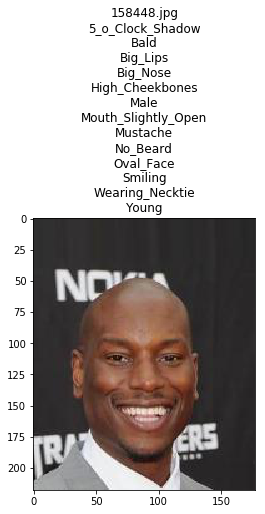

In [115]:
sample_img, sample_img_meta = show_sample_image(nb=1)

Now we use the traned encoder to create a latent representation of the image above.

In [262]:
z = encode_image(sample_img.astype(np.float32) / 255., np.array(sample_img_meta), encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

latent sample:
 [ 0.53124964  1.457325   -0.75365996  0.20048892 -0.537048   -1.4922919
 -0.40194982 -0.29691982 -2.435944   -1.583541   -0.39545324 -0.45716962
 -2.4105191  -0.13122278 -0.73344874 -0.12106702]


Using the latent representation we can visualize how the decoder reconstructed the original image. The reconstructed image is blurry as expected using a VAE. But we can see a strong similarity with the original image: gender, clothes color, hairs, smile, ...

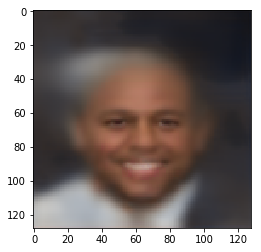

In [263]:
ret = decode_embedding(z, sample_img_meta, decoder)
plt.imshow(ret[0])
plt.show()

**1.B.4. Choose two celebrity faces from the dataset that differ according to two attributes and taking advantages of alterations of the latent representations image morph from one to the other.**

The following attributes are available in our conditioning data.

In [256]:
meta_cols = df_celeb.columns[1:].values
meta_cols

array(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair',
       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee',
       'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male',
       'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
       'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'], dtype=object)

The helper function below is adapted from [CompuFest](https://github.com/Harvard-IACS/2019-computefest/blob/master/Wednesday/auto_encoder/VAE_Solutions.ipynb).

In [178]:
def display_manifold(decoder, height, width, base_vec, bound_x=15, bound_y=15, axis_x=0, axis_y=1, n=15,
                     desc_x = 'x', desc_y = 'y', file_out=None):
    '''
    The function takes a latent representation and 
    applies an interpolation on its values according to two conditioning attributes
    in order to generate gradual changes in the reconstructed images.
    
    Arguments:
        decoder: trained decoder
        height: height of images to generate
        width: width of images to generate
        base_vec: latent representation to use.
        bound_x: the first conditioning attribute will vary within the interval [-bound_x, +bound_x]
        bound_y: the second conditioning attribute will vary within the interval [-bound_y, +bound_y]
        axis_x: the index of the first conditioning attribute in the latent representation
        axis_y: the index of the first conditioning attribute in the latent representation
        n: n**2 images will be generated
        desc_x: the name of the first conditioning attribute
        desc_y: the name of the second conditioning attribute
        file_out: file for saving the resulting plot
        
    '''
    
    figure = np.zeros((height * (n if bound_y > 0 else 1), width * (n if bound_x > 0 else 1), 3))
    grid_x = np.linspace(-bound_x, bound_x, n) if bound_x > 0 else [0]
    grid_y = np.linspace(-bound_y, bound_y, n) if bound_y > 0 else [0]
    individual_outputs = []

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = base_vec.copy()
            z_sample[axis_x] = xi 
            z_sample[axis_y] = yi 

            x_decoded = decoder.predict(np.expand_dims(z_sample, axis=0))
            sample = np.clip(x_decoded[0], 0, 1)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = sample
            individual_outputs.append(sample)

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.xlabel(desc_x)
    plt.ylabel(desc_y)
    if file_out is not None:
        plt.savefig(file_out, dpi=200, bbox_inches='tight')
    return figure, individual_outputs

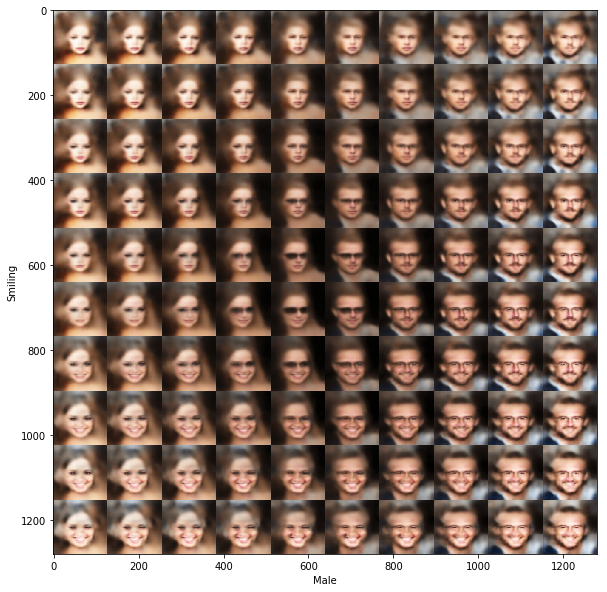

In [194]:
dim1 = 'Male'
dim2 = 'Smiling'
base_vec = np.array(list(z[0]) + sample_img_meta)
rendering, _ = display_manifold(
                                decoder, 
                                HEIGHT, 
                                WIDTH, 
                                base_vec, 
                                bound_x=15, 
                                bound_y=15, 
                                axis_x=LATENT_DIM + np.where(meta_cols==dim1)[0][0], 
                                axis_y=LATENT_DIM + np.where(meta_cols==dim2)[0][0], 
                                n=10,
                                desc_x = dim1,
                                desc_y = dim2,
                                file_out = 'rendering_celeba_' + dim1.lower() + '_' + dim2.lower() + '.png'
                                )

**1.B.5. Generate and visualise around 15 celebrity faces not in the training set.**

The function below generates a randon count of images using the decoder, while conditioning it on the given attributes.

In [254]:
def generate_new_images_vae(nb=16, smiling=None, male=None, no_beard=None, attractive=None, 
                        bald=None, chubby=None, eyeglasses=None, young = None):
    sample_training_img, sample_training_img_meta = show_sample_image(nb=1, verbose=False)
    plt.clf();
    f, ax = plt.subplots(2, nb//2, figsize=(20,7));
    for i in range(nb):
        meta=2*np.random.rand(meta_cols.shape[0])-1
        meta[2] = attractive if attractive else meta[2]
        meta[4] = bald if bald else meta[4]
        meta[13] = chubby if chubby else meta[13]
        meta[15] = eyeglasses if eyeglasses else meta[15]
        meta[20] = male if male else meta[20]
        meta[24] = no_beard if no_beard else meta[24]
        meta[31] = smiling if smiling else meta[31]
        meta[39] = young if young else meta[39]
        z1 = np.random.rand(LATENT_DIM, LATENT_DIM)
        ret = decode_embedding(z1, meta, decoder)
        ax[i%2][i//2].imshow(ret[0])
        ax[i%2][i//2].set_title('generated img {}'.format(i))
    ax[0][0].imshow(sample_training_img)
    ax[0][0].set_title('training img')

<Figure size 720x360 with 0 Axes>

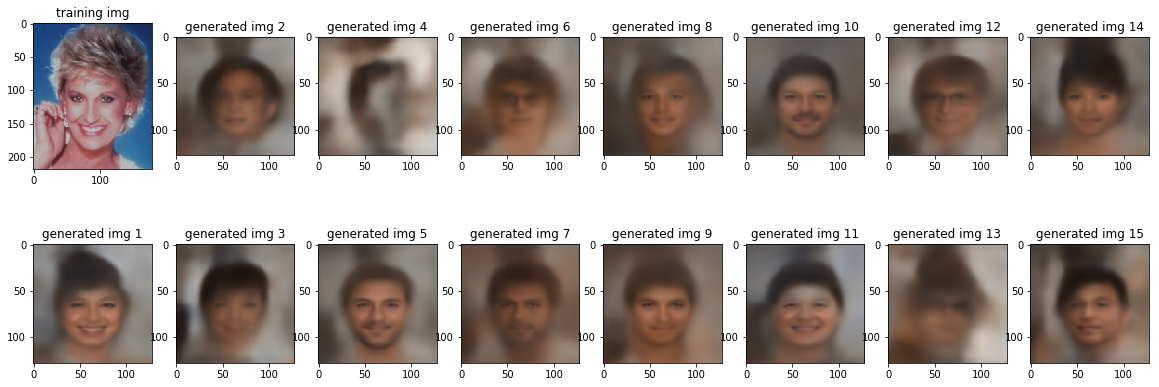

In [264]:
generate_new_images_vae()

Our variational autoencoder produces blurry and non-photorealistic faces. We can observe the this behaviour, especially when comparing with natural images from the CelebA database (see first image). This is a motivation to built generative adversarial networks.

### Section C: Building and Training a DCGAN Model

A Generative Adverserial Network is an old idea arising from the game theory, typically consists of two neural networks, a generative neural network and a discriminative neural network. The generative part is responsible for taking noise as input and generating 'fake' samples. The discriminative part tries to evaluate and distinguish the generated samples from 'true' samples. It is important that both learns equally during training and converge together. A typical situation occurs when the discriminative network becomes much more better at recognizing fakes, causing the generative network to be stucked.  

Deep Convolutional Generative Adversarial (DCGAN) are GAN which use convolutional layers.

**1.C.1. Create and compile a DCGAN model for the celebrity faces dataset.  Print summaries for the discriminator and generator models.**

In [342]:
SPATIAL_DIM = 64 # Spatial dimensions of the images.
LATENT_DIM_GAN = 100 # Dimensionality of the noise vector.
BATCH_SIZE_GAN = 32 # Batchsize to use for training.

FILTER_SIZE = 5 # Filter size to be applied throughout all convolutional layers.
NET_CAPACITY = 16 # General factor to globally change the number of convolutional filters.

PROGRESS_INTERVAL = 80 # Number of iterations after which current samples will be plotted.
ROOT_DIR = 'visualization' # Directory where generated samples should be saved to.

if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)
    
TOTAL_SAMPLES = df_celeb.shape[0]

**Discriminator**

The discriminator can be any image classifier, even a random tree.  It takes an image of a given shape and outputs a vector. We use an encoder block, consisting of a convolution, batch normalization and another convolution with strinding to downscale the image by two and another batch normalization. 

In [326]:
def add_encoder_block(x, filters, filter_size):
    x = Conv2D(filters, filter_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

The discriminator creates a 3d input block for RGB images, followed by four times encoding blocks, then we have average pooling, a dense sigmoid with a single output probability. Usually people emphasize in building a really powerful discriminator, leaving the generator simple.

In [327]:
def build_discriminator(start_filters, spatial_dim, filter_size):
    inp = Input(shape=(spatial_dim, spatial_dim, 3))
    
    # Encoding blocks downsample the image.
    x = add_encoder_block(inp, start_filters, filter_size)
    x = add_encoder_block(x, start_filters * 2, filter_size)
    x = add_encoder_block(x, start_filters * 4, filter_size)
    x = add_encoder_block(x, start_filters * 8, filter_size)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=inp, outputs=x)

**Generator**

The generator works the other way around. It starts with a small vector and generates an image. We have a decoder block Conv2D+BN+LeakyRelu used several times in the generator architecture.

In [328]:
def add_decoder_block(x, filters, filter_size):
    x = Deconvolution2D(filters, filter_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

The input of the generator is a noise vector of the latent dimension, which the generator projects into a larger four resolution image. First we upsample with the dense layer, in order to have enough values to reshape into a first block that will be the same dimension as the last block in the discriminator architecture (4 x 4 x number of filters in the last layer of discriminator). Then we apply batch normalization and we reshape the result into a 3d tensor. Then we apply a couple of decoder blocks and a final convolution layer, which has 3 channels.    

In [329]:
def build_generator(start_filters, filter_size, latent_dim):
    inp = Input(shape=(latent_dim,))
    
    # Projection.
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)
    
    # Decoding blocks upsample the image.
    x = add_decoder_block(x, start_filters * 4, filter_size)
    x = add_decoder_block(x, start_filters * 2, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)    
    
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    return Model(inputs=inp, outputs=x)

**DCGAN**

We define the discriminator model and compile it. Then we define the generator model, but we don't need to compile because we do not use the generator by its own. We finally define the full setup using the two. Going from noise, we have added the generator, and on the top we added the disciminator and made a joined model. 
During update of the full model, the discriminator weights have to be fixed. Before compiling the full setup, we have to set the discriminator model not be trainable, by freezing its weights and telling that the only part of the full network that needs to be trained is the generator. 

If we change the order above, the discriminator could become not trainable at all, it will not learn anything. The above makes sure that it is updated at the right time. The wrong order could also cause the discriminator to constantly updating in two different directions. The order above ensures that the discriminator is updated at the right time and frozen when it has to be. Therefore if we train the whole model, it will just update the generator, and when we train the discriminator, it will only update the discriminator.

In [330]:
def construct_models(verbose=False):
    # 1. Build discriminator.
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    # 2. Build generator.
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM_GAN)

    # 3. Build full GAN setup by stacking generator and discriminator.
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False # Fix the discriminator part in the full setup.
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002), metrics=['mae'])

    if verbose: # Print model summaries for debugging purposes.
        generator.summary()
        discriminator.summary()
        gan.summary()
    return generator, discriminator, gan

In [331]:
generator_celeb, discriminator_celeb, gan_celeb = construct_models(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_132 (InputLayer)       (None, 100)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 2048)              206848    
_________________________________________________________________
batch_normalization_131 (Bat (None, 2048)              8192      
_________________________________________________________________
reshape_80 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 8, 8, 64)          204864    
_________________________________________________________________
batch_normalization_132 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

**1.C.2. Train the model on the images in the celeba dataset.**

Training a GAN is hard and slow. The best way to do this is to write our own training loop:

1) select a number of real images from the training set

2) generate a number of fake images by sampling a random vector and predicting images from them using the generator

3) train the discriminator using train_on_batch, this means all the real imagines are trained with label 1, the fake images are trained with label 0

4) sample a new random vector 

5) train the full model on the random vector using train_on_batch, this will update just the generator by telling him that all the label is 1.

train_on_batch is a single gradient update on 1 batch,this allows a quick update of the network.

In [332]:
def get_real_celebrity(df, size, total):
    '''
     Select 'size' real images randomly
    '''
    cur_files = df.sample(frac=1).iloc[0:size]
    X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3))
    for i in range(0, size):
        file = cur_files.iloc[i]
        img_uri = 'data/celeb/img_align_celeba/' + file.image_id
        img = cv2.imread(img_uri)
        img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
        img = np.flip(img, axis=2)
        img = img.astype(np.float32) / 127.5 - 1.0
        X[i] = img
    return X

In [333]:
def plot_image(x):
    # helper function for plotting images
    plt.imshow(x * 0.5 + 0.5)

In [344]:
def run_training(generator, discriminator, gan, df=df_celeb, start_it=0, num_epochs=1000, get_real_images=get_real_celebrity):
    
        
    config_name = 'gan_cap' + str(NET_CAPACITY) + '_batch' + str(BATCH_SIZE_GAN) + '_filt' + str(FILTER_SIZE) + '_disc' + str(DISC_UPDATES) + '_gen' + str(GEN_UPDATES)
    folder = os.path.join(ROOT_DIR, config_name)

    if not os.path.isdir(folder):
        os.mkdir(folder)
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

    for epoch in range(num_epochs):
        
        loss_discriminator = []
        loss_generator = []
        for it in range(200): 

            # Update discriminator
            # Step 1-3: a the end of each loop, the weights of the discriminator have been updated
            #           to learn how to recognize fake images as fake, and real as real
            for i in range(DISC_UPDATES): 
                # Fetch real images
                imgs_real = get_real_images(df, BATCH_SIZE_GAN, TOTAL_SAMPLES)

                # Generate fake images
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
                imgs_fake = generator.predict(noise)

                # train the discriminator on real images with label 1
                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE_GAN]))[1]
                # train the discriminator on fake images with label 0
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE_GAN]))[1]
            
            # Progress visualizations
            # no training is done here
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                # We sample separate images.
                num_vis = min(BATCH_SIZE_GAN, 8)
                imgs_real = get_real_images(df, num_vis, TOTAL_SAMPLES)
                noise = np.random.randn(num_vis, LATENT_DIM_GAN)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plot_image(obj_plot[b]) 
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(folder, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()  

            # Update generator
            # Step 4-5: at the end of each loop, the generator has learn to generate fake images labelled real
            #           the discriminator is not updated since it was frozen
            loss = 0
            y = np.ones([BATCH_SIZE_GAN, 1]) 
            for j in range(GEN_UPDATES):
                # sample new noise at each step in order to avoid vanishing gradient
                noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
                # train the generator on noise with label 1
                loss += gan.train_on_batch(noise, y)[1]
            
            # Save lost
            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)        
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

        # Progress visualization.
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()
    return generator, discriminator, gan

Epoch 499


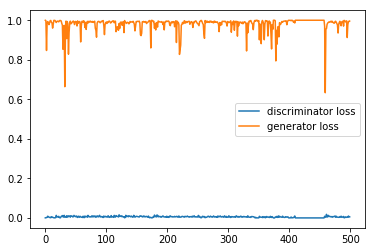

In [351]:
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.
generator_celeb, discriminator_celeb, gan_celeb = run_training(generator_celeb, 
                                                               discriminator_celeb, 
                                                               gan_celeb, 
                                                               num_epochs=500, 
                                                               df=df_celeb)

Saving the new weights.

In [352]:
generator_celeb.save_weights('model/generator_celeb.w')
discriminator_celeb.save_weights('model/discriminator_celeb.w')
gan_celeb.save_weights('model/gan_celeb.w')

generator_celeb_json = generator_celeb.to_json()
with open("model/generator_celeb.json", "w") as json_file:
    json_file.write(generator_celeb_json)
    
discriminator_celeb_json = discriminator_celeb.to_json()
with open("model/discriminator_celeb.json", "w") as json_file:
    json_file.write(discriminator_celeb_json)
    
gan_celeb_json = gan_celeb.to_json()
with open("model/gan_celeb.json", "w") as json_file:
    json_file.write(gan_celeb_json)

**1.C.3. Generate and visualise around 15 celebrity faces.**

In [347]:
def generate_new_faces_gan(generator, nb_faces=7):
    '''
        use the trained generator to generate unseen faces
    '''
    plt.figure(figsize=(nb_faces * 3, 3))

    for i in range(nb_faces):
        noise = np.random.randn(1, LATENT_DIM_GAN) 
        pred_raw = generator.predict(noise)[0]
        pred = pred_raw * 0.5 + 0.5
        plt.subplot(1, nb_faces, i + 1)
        plt.imshow(pred)
    plt.show()

The following faces are unseen faces generated by our DCGAN.

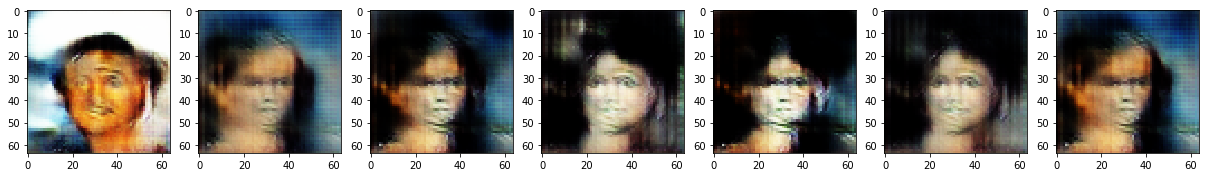

In [354]:
generate_new_faces_gan(generator_celeb, nb_faces=7)

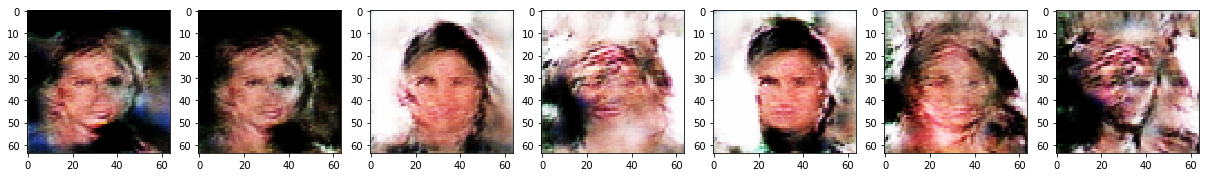

In [348]:
generate_new_faces_gan(generator_celeb, nb_faces=7)

Compared to the ones generated by our previous VAE, we can see real improvement in the image quality.

<Figure size 720x360 with 0 Axes>

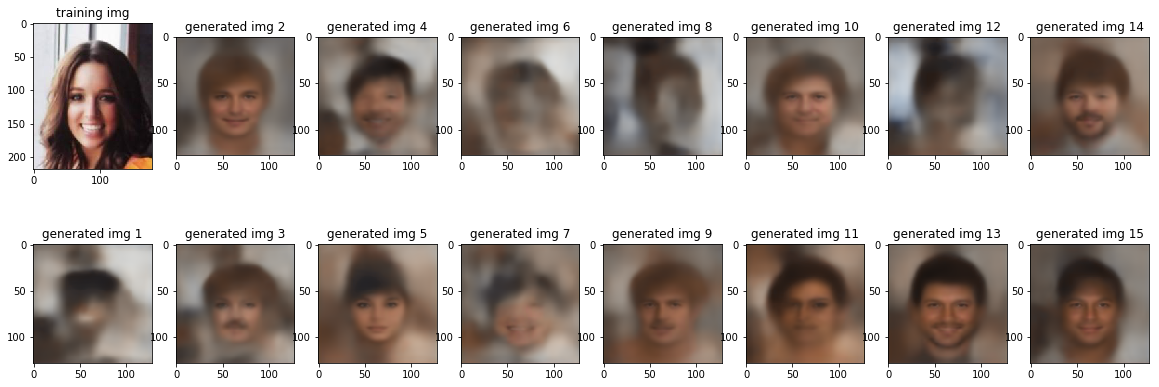

In [265]:
generate_new_images_vae()

## Part 2: VAE-GANIME

Wikipedia describes [Anime]() as follows:

Anime is hand-drawn and computer animation originating from or associated with Japan.  

The word anime is the Japanese term for animation, which means all forms of animated media. Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

Given a dataset of anime faces and we aim to create a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Section A: Preparing the Data 

**2.A.1.** Download the dataset from [Anime-Face Dataset](https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip). It contains over 20K anime faces in the form of 64x64 images.

In [4]:
'''r = requests.get('https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
'''

In [355]:
def show_sample_anime(nb=3, total=TOTAL_SAMPLES, verbose=True):
    '''
     select and display random anime faces
    '''
    anime_faces = glob.glob('data/anime-face/*.png')
    f, ax = plt.subplots(1, nb, figsize=(10,5))
    for i in range(nb):
        idx = random.randint(0, len(anime_faces))
        img_uri = anime_faces[idx]
        img = skimage.io.imread(img_uri)  
        if verbose:
            if nb > 1:
                ax[i].imshow(img)
                ax[i].set_title(img_uri)
            else:
                ax.imshow(img) 
                ax.set_title(img_uri)
        
    return img

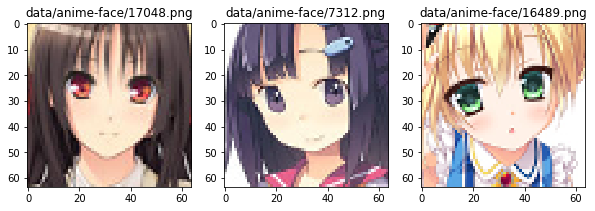

In [273]:
sample_anime = show_sample_anime()

### Section B: Building and Training a DCGAN


**2.B.1. Create and compile a DCGAN model for the anime faces dataset.  Print summaries for the generator and discriminator models**

We use the same DCGAN architecture as for the celebrity faces.

In [356]:
generator_anime, discriminator_anime, gan_anime = construct_models(verbose=False)

**2.B.2. Train the model on the images in the anime faces dataset.**

In [357]:
anime_faces = glob.glob('data/anime-face/*.png')

In [361]:
def get_real_anime(df=anime_faces, size=BATCH_SIZE, total=TOTAL_SAMPLES):
    '''
     returns a vector of random anime faces
    '''
    X = np.empty(shape=(size, SPATIAL_DIM, SPATIAL_DIM, 3)) # prepare an empty vector
    images_idx = np.random.randint(0, len(anime_faces), size) # select random indices
    i = 0
    for idx in images_idx: # loop through the images and fill the vector
        img_uri = df[idx]
        img = cv2.imread(img_uri)
        img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
        img = np.flip(img, axis=2)
        img = img.astype(np.float32) / 127.5 - 1.0
        X[i] = img
        i = i + 1
    return X

In [359]:
TOTAL_SAMPLES = len(anime_faces)
ROOT_DIR = 'visualization_anime' # Directory where generated samples should be saved to.
if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)

Epoch 499


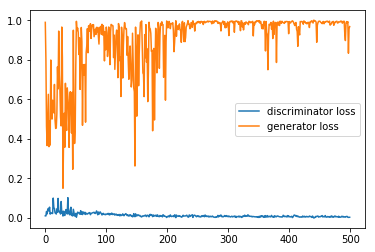

In [364]:
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.
generator_anime, discriminator_anime, gan_anime = run_training(generator_anime, discriminator_anime, gan_anime,
                                                               df=anime_faces, start_it=0, num_epochs=500, 
                                                               get_real_images=get_real_anime)

In [366]:
generator_anime.save_weights('model/generator_anime.w')
discriminator_anime.save_weights('model/discriminator_anime.w')
gan_anime.save_weights('model/gan_anime.w')

generator_anime_json = generator_anime.to_json()
with open("model/generator_anime.json", "w") as json_file:
    json_file.write(generator_anime_json)
    
discriminator_anime_json = discriminator_anime.to_json()
with open("model/discriminator_anime.json", "w") as json_file:
    json_file.write(discriminator_anime_json)
    
gan_anime_json = gan_anime.to_json()
with open("model/gan_anime.json", "w") as json_file:
    json_file.write(gan_anime_json)

**2.B.3. Generate and visualise around 15 anime faces not in the training set.**

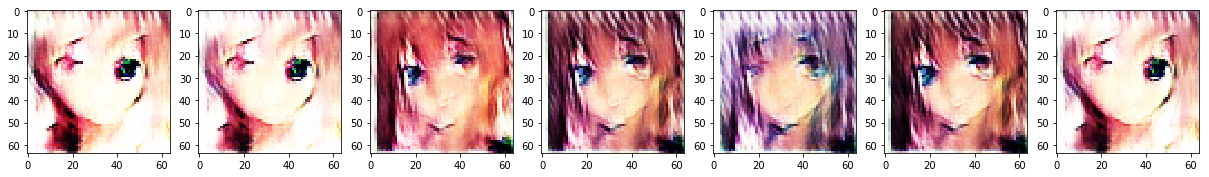

In [365]:
generate_new_faces_gan(generator_anime, nb_faces=7)

The generated images quality is less good compared to original samples. We observed that the average generator loss did not improve after epoch 80. Dicriminator and generator appear not to converge. We might want to have a closer look at the number of updates made during each training cycle. We can also want to look at the batch size and increase image resolution to 128px. 

This motivates combining VAE and GAN, where the generator will not work on a random noise, but will use a latent representation, sampled from a normal distribution of encoder output. This would give us more control on how the generator work, and might have positive gain on the image quality.

### Section C: Building and Training a VAE-GAN

From our experience, VAE is accessible to train given an explicit distribution assumption (Gaussian) for both latent representation and images. GAN does not have any assumption on the imags distributions and produces clearer images ([source](https://mc.ai/generate-anime-character-with-variational-auto-encoder/)). Numerous practical applications of GANs are found in this [GitHub repository](https://github.com/nashory/gans-awesome-applications). A PyTorch GAN implementation for anime faces can be found [here](https://github.com/jayleicn/animeGAN). [Another implementation](https://github.com/tdrussell/IllustrationGAN) based on TensorFlow is also available. Those images are nice, but few ghosts are present.

The combination of variational autoencoders and generative adversarial networks outperforms traditional VAEs. A GAN discriminator is used in place of a VAE’s decoder to learn the loss function. The encoder encodes the image x into a latent representation z while the decoder tries to reconstruct x from the latent vector. This reconstruction is fed to the discriminator of the GAN in order to learn the higher-level image similarity. The VAE and GAN are usually trained simultaneously using the loss function which includes the prior regularization term from the encoder, the reconstruction error, and the style error from the GAN. [source](https://github.com/qyhboy/Tensorflow-MultiGPU-VAE-GAN)

**2.C.1. Create and compile a VAE-GAN model for the anime faces dataset.  Print summaries for the encoder, decoder and discriminator models**

We use the implementation of the original paper from Larsen et. al. available [here](https://github.com/crmaximo/VAEGAN). We slightly modify it to work with our anime face dataset.

VAE Sampling function from a normal distribution.

In [283]:
def vaegan_sampling(args):
    mean, logsigma = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], 512), mean=0., stddev=1.0)
    return mean + K.exp(logsigma / 2) * epsilon

Encoder is made of 4 blocks of COnv2D+BN+LeakyRelu, at the end, the mean and standard deviation of the embeddings are produces as latent space.

In [291]:
def vaegan_encoder(kernel, filter, rows, columns, channel):
    X = Input(shape=(rows, columns, channel))
    model = Conv2D(filters=filter, kernel_size=kernel, strides=2, padding='same')(X)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Flatten()(model)

    mean = Dense(512)(model)
    logsigma = Dense(512, activation='tanh')(model)
    latent = Lambda(vaegan_sampling, output_shape=(512,))([mean, logsigma])
    meansigma = Model([X], [mean, logsigma, latent])
    return meansigma

The decoder has a reverse architecture of the encoder. There is no conditioning.

In [292]:
def vaegan_decoder(kernel, filter, rows, columns, channel):
    X = Input(shape=(512,))

    model = Dense(filter*8*rows*columns)(X)
    model = Reshape((rows, columns, filter * 8))(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=filter, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=channel, kernel_size=kernel, strides=2, padding='same')(model)
    model = Activation('tanh')(model)

    model = Model(X, model)
    return model

The GAN discriminator is 4 Conv2D hidden layers with BN and LeakyRelu.

In [319]:
def vaegan_discriminator(kernel, filter, rows, columns, channel):
    X = Input(shape=(rows, columns, channel))

    model = Conv2D(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(X)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)


    dec = BatchNormalization(epsilon=1e-5)(model)
    dec = LeakyReLU(alpha=0.2)(dec)
    dec = Flatten()(dec)
    dec = Dense(1, activation='sigmoid')(dec)

    output = Model([X], [dec, model])
    return output
    #return Model(inputs=X, outputs=dec)

The following hyperparameters are used as defined in the original paper. 

In [294]:
batch_size = 512
rows = 64
columns = 64
channel = 3
epochs = 20000

datasize = len(anime_faces)
#noise = np.random.normal(0, 1, (batch_size, 256))
# optimizers
SGDop = SGD(lr=0.0003)
ADAMop = Adam(lr=0.0002)


**Encoder**

In [295]:
E = vaegan_encoder(NET_CAPACITY, FILTER_SIZE, SPATIAL_DIM, SPATIAL_DIM, channel)
E.compile(optimizer=SGDop, loss='mse')
E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_122 (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_657 (Conv2D)             (None, 32, 32, 5)    3845        input_122[0][0]                  
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 32, 32, 5)    20          conv2d_657[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_41 (LeakyReLU)      (None, 32, 32, 5)    0           batch_normalization_100[0][0]    
__________________________________________________________________________________________________
conv2d_658

**Decoder/Generator**

In [296]:
G = vaegan_decoder(NET_CAPACITY, FILTER_SIZE, SPATIAL_DIM, SPATIAL_DIM, channel)
G.compile(optimizer=SGDop, loss='mse')
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_123 (InputLayer)       (None, 512)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 163840)            84049920  
_________________________________________________________________
reshape_79 (Reshape)         (None, 64, 64, 40)        0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 64, 64, 40)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 40)        0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 128, 128, 20)      204820    
_________________________________________________________________
batch_normalization_105 (Bat (None, 128, 128, 20)      80        
__________

**Discriminator**

In [320]:
D = vaegan_discriminator(5, 32, rows, columns, channel)
D.compile(optimizer=SGDop, loss='mse')
D.summary()
D_fixed = vaegan_discriminator(5, 32, rows, columns, channel)
D_fixed.compile(optimizer=SGDop, loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_130 (InputLayer)       (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_677 (Conv2D)          (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_678 (Conv2D)          (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_120 (Bat (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_679 (Conv2D)          (None, 8, 8, 256)         819456    
__________

**VAE**

In [ ]:
# VAE
X = Input(shape=(SPATIAL_DIM, SPATIAL_DIM, channel))
E_mean, E_logsigma, Z = E(X)
output = G(Z)
G_dec = G(E_mean + E_logsigma)
D_fake, F_fake = D(output)
D_fromGen, F_fromGen = D(G_dec)
D_true, F_true = D(X)
VAE = Model(X, output)
kl = - 0.5 * K.sum(1 + E_logsigma - K.square(E_mean) - K.exp(E_logsigma), axis=-1)
crossent = 64 * mse(K.flatten(X), K.flatten(output))
VAEloss = K.mean(crossent + kl)
VAE.add_loss(VAEloss)
VAE.compile(optimizer=SGDop)

**2.C.2. Train your model on the images in the anime faces dataset.**

In [ ]:
for epoch in range(1):
    
    dataset = get_real_anime(df=anime_faces, size=batch_size, total=TOTAL_SAMPLES)
    
    latent_vect = E.predict(dataset)[0]
    encImg = G.predict(latent_vect)
    noise = np.random.normal(0, 1, (batch_size, batch_size))
    fakeImg = G.predict(noise)

    DlossTrue = D_true.train_on_batch(dataset, np.ones((batch_size, 1)))
    DlossEnc = D_fromGen.train_on_batch(encImg, np.ones((batch_size, 1)))
    DlossFake = D_fake.train_on_batch(fakeImg, np.zeros((batch_size, 1)))

    cnt = epoch
    while cnt > 3:
        cnt = cnt - 4

    if cnt == 0:
        GlossEnc = G.train_on_batch(latent_vect, np.ones((batch_size, 1)))
        GlossGen = G.train_on_batch(noise, np.ones((batch_size, 1)))
        Eloss = VAE.train_on_batch(dataset, None)

    chk = epoch

    while chk > 50:
        chk = chk - 51

    if chk == 0:
        D.save_weights('discriminator.h5')
        G.save_weights('generator.h5')
        E.save_weights('encoder.h5')

    print("epoch number", epoch + 1)
    print("loss:")
    print("D:", DlossTrue, DlossEnc, DlossFake)
    print("G:", GlossEnc, GlossGen)
    print("VAE:", Eloss)

print('Training done,saving weights')
D.save_weights('discriminator.h5')
G.save_weights('generator.h5')
E.save_weights('encoder.h5')
print('end')